In [54]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotnine as p9
from functools import partial
from collections.abc import Callable
import itertools

In [118]:
# create the grid of pairs (consumption today, tomorrow)
amounts_consumption = np.linspace(0, 1000, 50).round(0).astype(int)

def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

outcomes_wellbeing = expand_grid({'consumption_today': amounts_consumption, 'consumption_tomorrow': amounts_consumption})

In [119]:
def transform_wellbeing(consumption, strength_of_diminishing: float): 
    """
    Wellbeing also known as 'utility', in economics jargon.
    Wooldridge associates the two terms in _Introductory Econometrics_ (Section 1-2).
    Cochrane's _Asset Pricing_ presents a convenient functional form.

    Expect strength_of_diminishing in [0, 1).
    strength_of_diminishing=0 implies, more consumption yields constant improvement in wellbeing.
    """

    wellbeing = ( 1 / (1 - strength_of_diminishing) ) * consumption**(1-strength_of_diminishing)

    return wellbeing

def transform_lifetime_wellbeing(
    wellbeing_func: Callable,
    consumption_today, 
    consumption_expected_tomorrow, 
    subjective_discount_factor: float
    ):
    """
    Wellbeing also known as 'utility', in economics jargon.
    Wooldridge associates the two terms in _Introductory Econometrics_ (Section 1-2).

    Cochrane's _Asset Pricing_ presents a convenient functional form.
    """

    wellbeing_today = wellbeing_func(consumption_today)
    wellbeing_expected_tomorrow = subjective_discount_factor * wellbeing_func(consumption_expected_tomorrow)
    lifetime_wellbeing = wellbeing_today + wellbeing_expected_tomorrow

    return lifetime_wellbeing

In [120]:
# classical discount factor equals 1 / risk_free_gross_rate; 
# suppose 5% risk free net rate
SUBJECTIVE_DISCOUNT_FACTOR = 1 / 1.05
STRENGTH_OF_DIMINISHING = 0.5

wellbeing_curve = partial(transform_wellbeing, strength_of_diminishing=STRENGTH_OF_DIMINISHING)

outcomes_wellbeing['lifetime_wellbeing'] = transform_lifetime_wellbeing(
    wellbeing_curve, 
    outcomes_wellbeing['consumption_today'], 
    outcomes_wellbeing['consumption_tomorrow'], 
    SUBJECTIVE_DISCOUNT_FACTOR
    )

In [ ]:
# 3d area plotly requires a particular data structure.
# examples reference: https://plotly.com/python/3d-surface-plots/
todays_wellbeing = outcomes_wellbeing.pivot(index='consumption_today', columns='consumption_tomorrow')['lifetime_wellbeing']

# choose x and y axis series to clarify the user's view.
# decision interacts with the 3d visual's angle presented
y=todays_wellbeing.index.values
x=todays_wellbeing.columns.values
z=todays_wellbeing.values.round(1)
titles_axes = dict(
    yaxis_title_text="Consumption Today",
    xaxis_title_text='Consumption <br>Expected Tomorrow', 
    zaxis_title_text="Lifetime Wellbeing"
    )

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

# better view in the web browser when autosize allowed
fig.update_layout(
    title=dict(text='Lifetime Wellbeing'), 
    scene_camera_eye=dict(x=2.5, y=0.88, z=0.5),
    )

# 3d plots axis titles have special access method, vs 2d
# reference: https://community.plotly.com/t/how-to-update-x-y-and-z-axes-titles-for-3d-surface-plots-within-a-subplot/45495
fig.update_scenes(**titles_axes)

fig.show()

In [184]:
fig.write_html("./docs/lifetime_wellbeing_plot.html", include_plotlyjs='cdn')

# Appendix

In [ ]:
# intuit how wellbeing curve varies with gamma
tunes_wellbeing = []
for g in [0, 0.1, 0.25, 0.5, 0.75, 0.9]:
    outcomes_wellbeing = transform_wellbeing(amounts_consumption, g)
    outcomes_wellbeing = pd.DataFrame({
        'consumption': amounts_consumption,
        'wellbeing': outcomes_wellbeing,
        'gamma': g
    })
    tunes_wellbeing.append(outcomes_wellbeing)

tunes_wellbeing = pd.concat(tunes_wellbeing, axis=0, ignore_index=True)

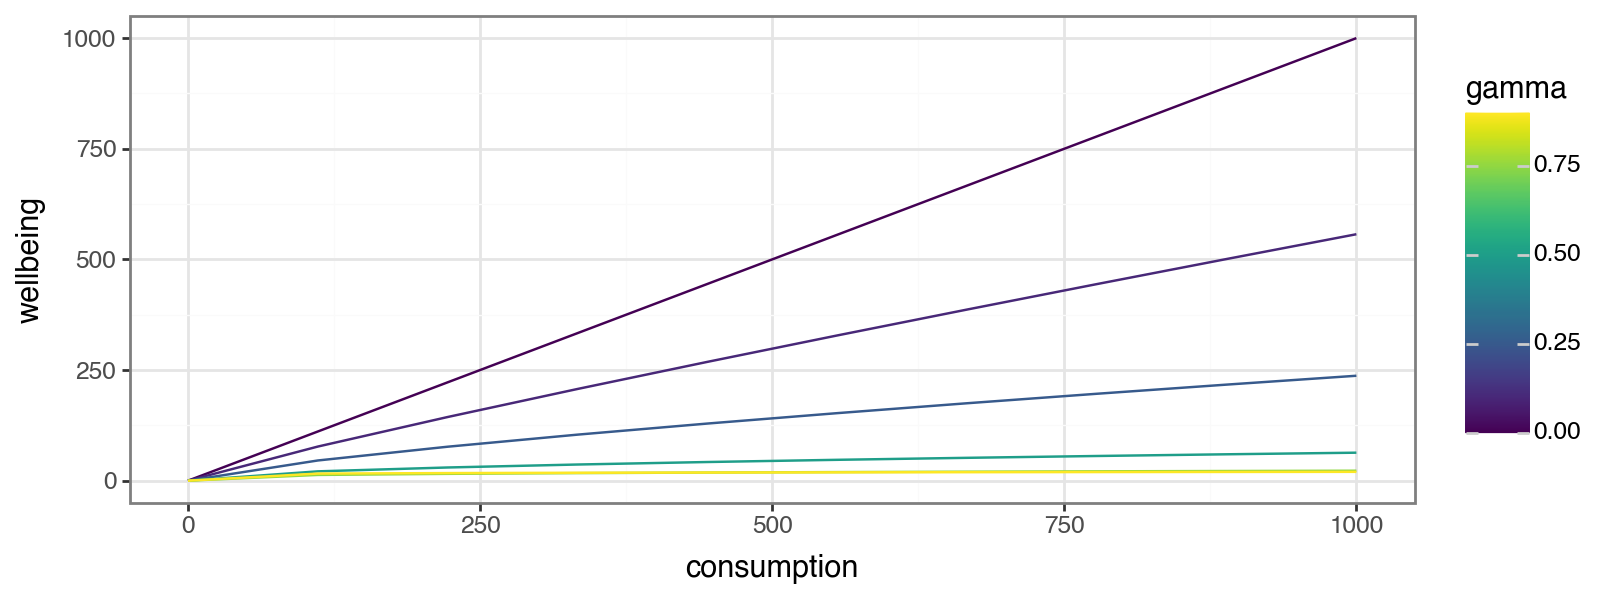

In [ ]:
(
    p9.ggplot(tunes_wellbeing) + 
    p9.theme_bw() + 
    p9.geom_line(p9.aes('consumption', 'wellbeing', color='gamma', group='gamma')) + 
    p9.theme(figure_size=(8,3))
)

In [168]:
# example shows the special data structure expected by plotly
# https://plotly.com/python/3d-scatter-plots/

# Read data from a csv
# z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
# z = z_data.values
# sh_0, sh_1 = z.shape
# x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
# fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
# fig.update_layout(title=dict(text='Mt Bruno Elevation'), autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))
# fig.show()

In [ ]:
# test: can i embed a plotly chart via html?
fig = go.Figure(data=[go.Scatter(x=[1, 2, 3], y=[1, 4, 9])])

# successful alternative: host via GitHub Pages
# https://community.plotly.com/t/how-to-display-plotly-graph-on-github-pages/44398/3
# steps:
    # enable GitHub Pages in my repo
    # write plot to html file
# fig.write_html("./docs/test_plot.html", include_plotlyjs='cdn')
# https://abrahamalex13.github.io/learning-to-price-assets/test_plot

# did not work: pasting below in Substack html editor
# <div class="plotly-plot"> {{ html_string }} </div>
# where html_string -> 
    # html_string = fig.to_html(full_html=False, include_plotlyjs='cdn')
    # print(html_string)